# Выбор локации для скважин

### Описание проекта

Нефтедобывающей компании нужно решить, где бурить новые скважины.

Шаги для выбора локации для скважин:
- В нефтеносном регионе ищут месторождения, для каждого определяют значения признаков, характеризующих нефть, и объём её запасов.
- Строят модель для предсказания и с её помощью оценивают объём запасов в новых скважинах.
- Выбирают скважины с самыми высокими предсказанными оценками запасов. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.
- Рассчитывают возможную общую прибыль как суммарную возможную прибыль отобранных месторождений.

#### Цель проекта

Используя модель машинного обучения, определить регион для бурения новых скважин, где добыча нефти принесёт наибольшую прибыль.

#### Задачи проекта

- Обучить модель для предсказания объёма запасов в новых скважинах.
- С помощью обученной модели выбрать скважины с самыми высокими оценками запасов.
- Проанализировать возможную прибыль и риски техникой *Bootstrap*.
- Определить регион с низким риском убытков и максимальной суммарной прибылью выбранных скважин.

#### Описание данных

Компанией собраны пробы нефти в трёх регионах: для каждого месторождения измерили характеристики нефти и объём её запасов.

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`,
- `/datasets/geo_data_1.csv`,
- `/datasets/geo_data_2.csv`.
  
Признаки в данных:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три значимых признака скважины;
- `product` — объём запасов сырья в скважине (тыс. баррелей).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

#### Условия задачи

- Для предсказания запасов сырья подходит только линейная регрессия, т.к. другие модели недостаточно предсказуемые.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них нужно выбрать регион с наибольшей средней прибылью.

### Установка и обновление библиотек

In [1]:
# обновляем версии библиотек
%pip install matplotlib==3.5.0 -q

Note: you may need to restart the kernel to use updated packages.


### Импорты

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from copy import deepcopy

### Константы и настройки

In [3]:
# фиксируем случайное состояние для воспроизводимости результатов
RANDOM_STATE = 42

# количество генерируемых подвыборок в бутстрапе
NUM_SUBSAMPLES = 1000

### Пользовательские функции

In [4]:
def plot_hist(df):
    """
    Строит гистограммы распределения значений 
    для всех числовых столбцов в таблице.
    """
    axes = df.hist(bins=50, figsize=(10, 5))
    plt.gcf().set_constrained_layout(True)
    for col, ax in zip(df.columns, axes.ravel()):
        ax.set_title('Гистограмма распределения признака ' + col)
        ax.set_xlabel(col)
        ax.set_ylabel('количество объектов')

    return axes

In [5]:
def corr_matrix(data, features=None, method='pearson', interval_cols=None):
    """
    Выводит матрицу корреляции количественных признаков features в данных data
    в виде тепловой карты.
    Дополнительный параметр:
    method - метод расчёта корреляции, по умолчанию 'pearson':
        'pearson' - корреляция Пирсона, 
        'spearman' - корреляция Спирмена,
        'kendall' - корреляция Кендалла,
        'phik' - корреляция фи.
    """
    if method == 'pearson':
        method_name = 'Пирсона'
    elif method == 'spearman':
        method_name = 'Спирмена'
    elif method == 'kendall':
        method_name = 'Кендалла'
    elif method == 'phik':
        method_name = '$\phi_k$'
    else:
        print('Неправильно указан метод расчёта корреляций.')
        return None

    if features is None:
        features = data.columns
         
    # расчёт матрицы корреляции
    if method in [ 'pearson', 'spearman', 'kendall']:
        corr_data = data[features].corr(method=method)
        vmin = -1
        vmax = 1
        center = 0
        cmap='bwr'
    elif method == 'phik':
        if 'phik' in dir():
            corr_data = data[features].phik_matrix(interval_cols=interval_cols)
            vmin = 0
            vmax = 1
            center = 0.5
            cmap='Greens'
        else:
            print("Module 'phik' not imported.")
            return None
    
    # строим тепловую карту по матрице корреляции
    mask = np.triu(np.ones_like(corr_data, dtype=bool))
    ax = sns.heatmap(
        corr_data, 
        annot=True,
        fmt='.2f',
        square=True,
        cmap=cmap, 
        vmin=vmin,
        vmax=vmax,
        center=center,
        mask=mask,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Коэффициенты корреляции {method_name}')

    return ax

## Загрузка и подготовка данных

### Загрузка данных

In [ ]:
# путь к файлам по умолчанию
path_default = '/datasets/'
# путь к файлам на локальном компьютере
path_local_rel = '~/datasets/'
path_local = os.path.expanduser(path_local_rel)
# путь к файлам на внешнем сервере
path_remote = 'https://<LINK_REMOVED>/datasets/'

# определение расположения файлов
if os.path.exists(path_default):
    path = path_default
elif os.path.exists(path_local):
    path = path_local
else:
    path = path_remote
    
# загрузка данных из CSV файлов
geo_data_0 = pd.read_csv(path + 'geo_data_0.csv')
geo_data_1 = pd.read_csv(path + 'geo_data_1.csv')
geo_data_2 = pd.read_csv(path + 'geo_data_2.csv')

### Знакомство с данными

Для удобства дальнейшей работы создадим список с названиями загруженных датасетов.

In [7]:
# список с названиями датасетов
df_list = ['geo_data_0', 'geo_data_1', 'geo_data_2']

Посмотрим на первые строки таблиц и общую информацию о них.

In [8]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    # первые 5 строк таблицы
    display(eval(df_name).head())
    print()

geo_data_0:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



geo_data_1:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



geo_data_2:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    # общая информация о таблице
    print(eval(df_name).info())
    print()

geo_data_0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

geo_data_1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

geo_data_2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data co

**Выводы:**
- Каждый из трёх датасетов содержит по 100,000 записей.
- Структура датасетов одинакова: текстовый id и четыре непрерывных количественных признака.
- Пропущенные значения в датасетах отсутствуют.

### Предобработка данных

#### Обработка дубликатов

Проверим данные на наличие полных дубликатов записей.

In [10]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    # количество полных дубликатов
    print('Количество полных дубликатов:', eval(df_name).duplicated().sum())
    print()

geo_data_0:
Количество полных дубликатов: 0

geo_data_1:
Количество полных дубликатов: 0

geo_data_2:
Количество полных дубликатов: 0



Полные дубликаты отсутствуют.

Проверим количество уникальных id. В соответствии с описанием данных, id — уникальный идентификатор скважины, а значит количество уникальных значений в столбце `id` должно совпадать с количеством записей в таблице.

In [11]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    # количество уникальных id
    print('Количество уникальных id:', eval(df_name)['id'].nunique())
    print()

geo_data_0:


Количество уникальных id: 99990

geo_data_1:
Количество уникальных id: 99996

geo_data_2:
Количество уникальных id: 99996



Оказалось, что во всех трёх таблицах есть дубликаты — записи с одинаковым значением id. 

Посмотрим на них.

In [12]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    # количество дубликатов id
    print('Количество дубликатов id:', 
          eval(df_name).duplicated(subset='id').sum())
    # выводим записи с одинаковыми id
    display(
        eval(df_name)[eval(df_name).duplicated(subset='id', keep=False)]
        .sort_values(by='id')
    )
    print()

geo_data_0:
Количество дубликатов id: 10


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



geo_data_1:
Количество дубликатов id: 4


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



geo_data_2:
Количество дубликатов id: 4


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Наиболее вероятная причина появления пар дубликатов с одинаковыми id и отличающимися значениями признаков — на одной и той же скважине были взяты две пробы. 

Нет оснований считать, что записи расположены в хронологическом порядке и запись с большим индексом достоверная, а с меньшим — нет. Поэтому **усредним** значения признаков для записей с одинаковыми id, а затем удалим возникшие при этом полные дубликаты. После удаления дубликатов проверим результат: сравним количество записей и количество уникальных id.

In [13]:
for df_name in df_list:
    df  = eval(df_name)
    columns = df.columns.drop('id')
    # заменяем значения на средние для группы с одинаковым id
    df[columns] =  df.groupby('id')[columns].transform('mean')
    # удаляем полные дубликаты
    df.drop_duplicates(inplace=True)
    # название таблицы
    print(f'{df_name}:')
    print('Количество записей', len(eval(df_name)))
    print('Количество уникальных id:', eval(df_name)['id'].nunique())
    print()

geo_data_0:
Количество записей 99990
Количество уникальных id: 99990

geo_data_1:
Количество записей 99996
Количество уникальных id: 99996

geo_data_2:
Количество записей 99996
Количество уникальных id: 99996



#### Задание индексов

Теперь, когда id действительно уникальны, можно установить столбец `id` в таблицах в качестве индекса.

In [14]:
for df_name in df_list:
    # устанавливаем столбец 'id' в качестве индекса
    eval(df_name).set_index('id', inplace=True)
    # название таблицы
    print(f'{df_name}:')
    # первые 5 строк таблицы
    display(eval(df_name).head())
    print()

geo_data_0:


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647



geo_data_1:


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305



geo_data_2:


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Повторная проверка на дубликаты

После перевода `id` в индекс и перед обучением модели на данных их нужно проверить на наличие дубликатов — записей с одинаковым набором признаков.

In [15]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    print('Количество полных дубликатов:', eval(df_name).duplicated().sum())
    print()

geo_data_0:


Количество полных дубликатов: 0

geo_data_1:
Количество полных дубликатов: 0

geo_data_2:
Количество полных дубликатов: 0



Всё в порядке, дубликатов нет.

**Выводы:**
- Значения id скважин в каждой из таблиц оказались не уникальны: имеются пары записей с одинаковыми id.
- Каждая группа записей с одинаковым id заменена на одну запись с усреднёнными по группе значениями признаков.
- Записи с одинаковыми наборами признаков в таблицах отсутствуют.

### Исследовательский анализ данных

#### Анализ статистических характеристик

Для проверки данных на аномалии исследуем **статистические характеристики количественных признаков** с помощью метода `describe()`.

In [16]:
for df_name in df_list:
    # название таблицы
    print(f'{df_name}:')
    # статистические характеристики количественных признаков
    display(eval(df_name).describe().T.astype({'count': 'int'}))

geo_data_0:


,count,mean,std,min,25%,50%,75%,max
f0,99990,0.500433,0.871844,-1.408605,-0.072653,0.502340,1.073602,2.362331
f1,99990,0.250145,0.504422,-0.848218,-0.200849,0.250252,0.700640,1.343769
f2,99990,2.502642,3.248035,-12.088328,0.287784,2.516005,4.715035,16.003790
product,99990,92.499583,44.287881,0.000000,56.497903,91.847928,128.563699,185.364347


geo_data_1:


,count,mean,std,min,25%,50%,75%,max
f0,99996,1.141329,8.965692,-31.609576,-6.298525,1.153055,8.620875,29.421755
f1,99996,-4.796550,5.119850,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,99996,2.494526,1.703556,-0.018144,1.000021,2.011480,3.999904,5.019721
product,99996,68.824574,45.944079,0.000000,26.953261,57.085625,107.813044,137.945408


geo_data_2:


,count,mean,std,min,25%,50%,75%,max
f0,99996,0.001999,1.732031,-8.760004,-1.162288,0.009429,1.158428,7.238262
f1,99996,-0.002097,1.730376,-7.084020,-1.174805,-0.009580,1.163592,7.844801
f2,99996,2.495108,3.473435,-11.970335,0.130359,2.484236,4.858662,16.739402
product,99996,94.999383,44.747429,0.000000,59.452094,94.925613,130.585544,190.029838


По характеристикам синтетических признаков `f0`, `f1`, `f2` сложно судить о наличии аномальных значений в них, но по крайней мере признак `product` (объём запасов в скважине в тыс. баррелей) не содержит отрицательных значений и во всех трёх датасетах имеет один порядок величины.

#### Анализ распределений

Исследуем распределения значений признаков в данных. Для этого построим **гистограммы распределений** с помощью пользовательской функции `plot_hist`.

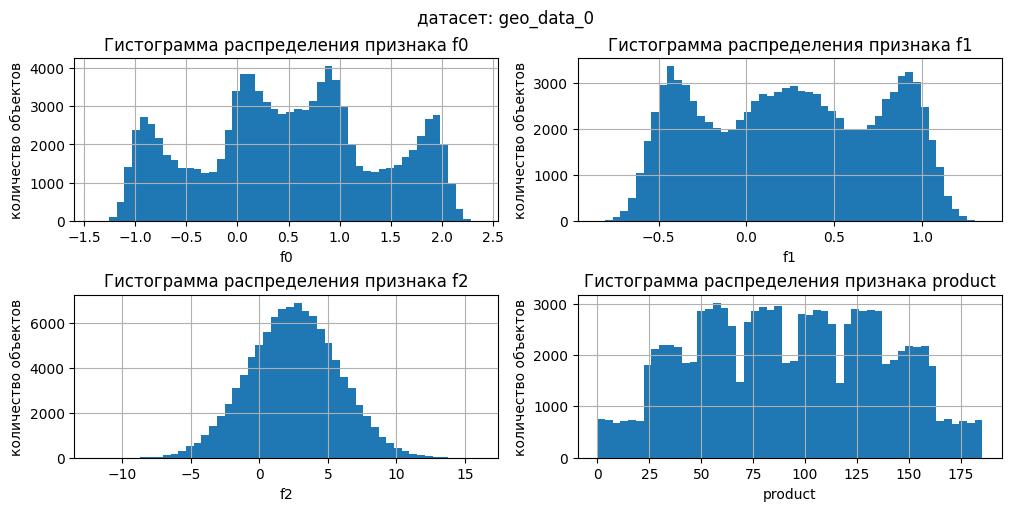

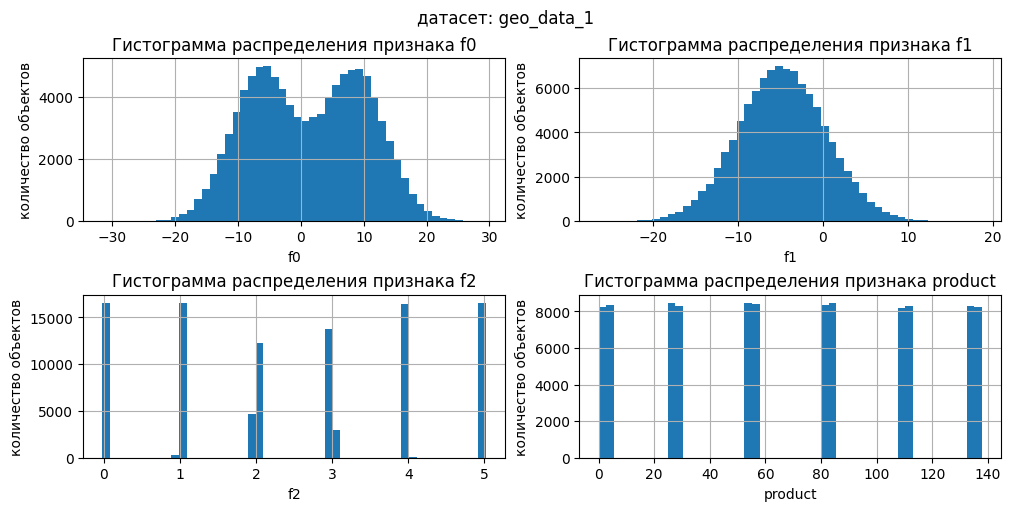

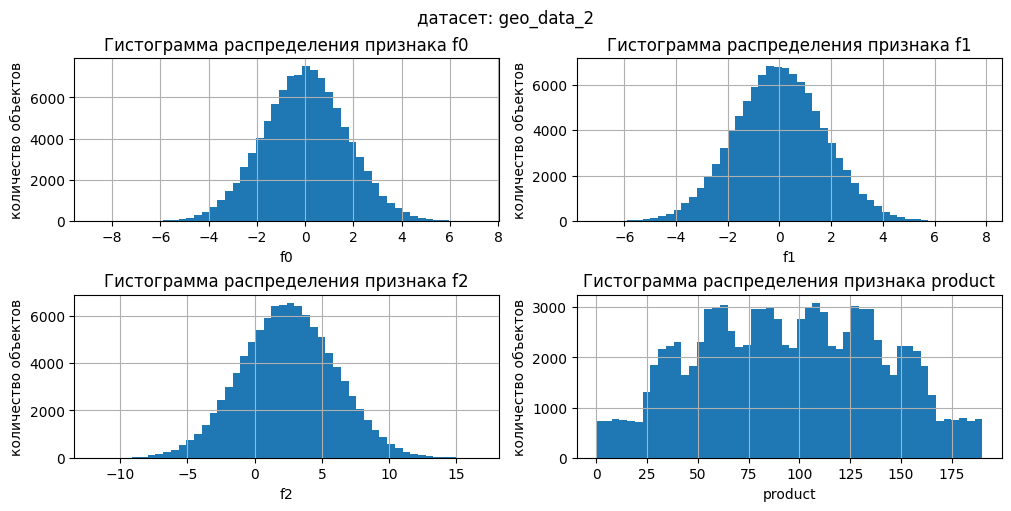

In [17]:
for df_name in df_list:
    df  = eval(df_name)
    # строим гистограммы для всех числовых столбцов
    plot_hist(df)
    # название графика
    plt.gcf().suptitle('датасет: ' + df_name)
    plt.show()

- В датасете `geo_data_0` признаки `f0`, `f1` и `product` имеют мультимодальное распределение с несколькими пиками. Признак `f2` имеет нормальное распределение.
- В датасете `geo_data_1` признак `f0` имеет бимодальное распределение с двумя пиками — сумму двух нормальных распределений, признак `f1` имеет нормальное распределение, а признаки `f2` и `product` квазидискретное распределение — их значения сгруппированы вокруг последовательности значений с равным интервалом.
- В датасете `geo_data_2` признаки `f0`, `f1` и `f2` имеют нормальное распределение. Целевой признак `product` имеет мультимодальное распределение с несколькими пиками.

Наличие нескольких пиков в распределении признаков указывает на то, что регионы 0 и 1 не однородны по характеристикам месторождений.

Для исследования выбросов в распределениях и сравнения характеристик распределений признаков между регионами объединим таблицы, добавив название датесета в новый столбец `dataset`, а затем построим диаграммы размаха для каждого признака с разбивкой по датасетам.

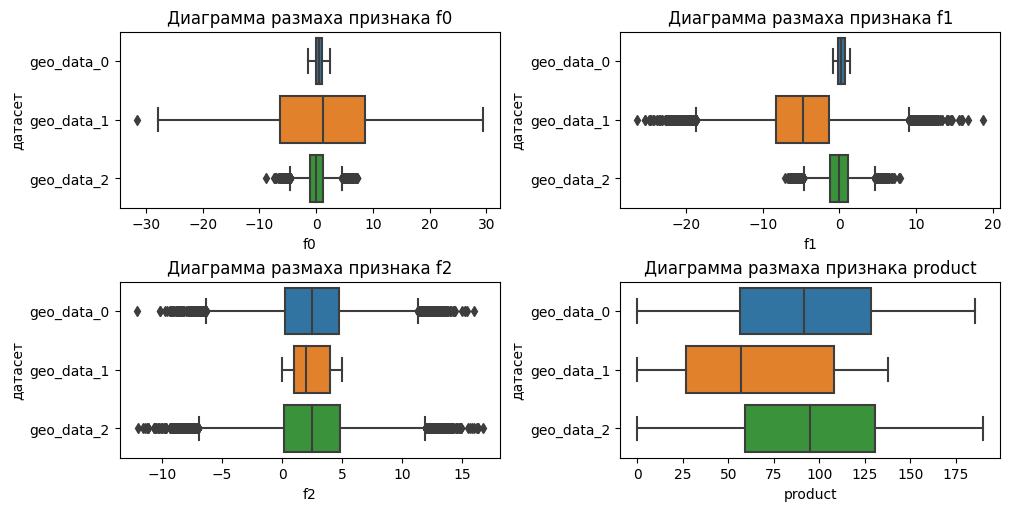

In [ ]:
# объединяем данные, добавив название датасета в столбец 'dataset'
# и сбрасываем индекс
geo_data = pd.concat(
    [eval(df_name).assign(dataset=df_name) for df_name in df_list]
).reset_index()

# создаём область построения графиков
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(10, 5), 
    constrained_layout=True
)

# строим графики
for i, col in enumerate(geo_data.columns.drop(['id','dataset'])):
    # индексы области построения
    r = i // 2
    c = i % 2
    ax = axes[r, c]
    # строим диаграмму размаха
    sns.boxplot(data=geo_data, x=col, y='dataset', ax=ax)
    ax.set_title('Диаграмма размаха признака ' + col)
    ax.set_ylabel('датасет')

Характеристики положения (медиана) и разброса (межквартильный интервал) входных признаков `f0`,  `f1` и `f2` отличаются между регионами. При этом регионы 0 и 2 демонстрируют некоторое сходство, а регион 1 от них заметно отличается.

Распределения целевого признака `product` тоже похожи в регионах 0 и 2, а в регионе 1 распределение смещено в сторону меньших значений.

**Выводы:**
- Аномалии и сильные выбросы в данных отсутствуют.
- Регионы 0 и 2 имеют похожие характеристики, а регион 1 от них заметно отличается.

При объединении данных для построения диаграмм размаха с разбивкой по датасетам было обнаружено, что попадаются одинаковые id скважин в разных датасетах. Из-за этого в объединённой таблице пришлось сбросить индекс.

Посчитаем количество повторяющихся id и посмотрим на соответствующие записи.

In [19]:
print('Количество дубликатов id:', geo_data.duplicated(subset='id').sum())

Количество дубликатов id: 31


In [20]:
# выводим первые 10 записей с одинаковыми id 
(geo_data[geo_data.duplicated(subset='id', keep=False)]
 .sort_values(by=['id', 'dataset'])
 .head(10)
)

,id,f0,f1,f2,product,dataset
45427,2tyMi,0.576679,-0.411140,-3.725859,69.292672,geo_data_0
227366,2tyMi,-1.789602,-1.359044,-4.840745,145.901447,geo_data_2
16752,5ssQt,-1.005117,0.268726,-0.407822,53.206029,geo_data_0
272879,5ssQt,-0.651825,0.782415,2.690636,120.108761,geo_data_2
14776,CXJ2r,1.799663,0.152615,2.308270,124.783815,geo_data_0
123076,CXJ2r,4.595329,-1.967882,4.000767,107.813044,geo_data_1
144727,D8TNs,-0.646266,3.667055,1.006161,30.132364,geo_data_1
261605,D8TNs,0.280382,0.061393,4.887870,114.943876,geo_data_2
58787,G6k8A,-0.332671,0.873613,0.056776,59.356289,geo_data_0
291242,G6k8A,3.021943,2.091350,2.325737,81.922702,geo_data_2


Возможное объяснение наличия одинаковых id может быть в том, что id скважины — это хэш от её названия, поэтому если в разных регионах встречаются скважины с одинаковыми названиями, то и id у них будут совпадать. Поэтому нет достаточных оснований, чтобы считать, что это одни и те же скважины и из-за этого между регионами есть пересечения.

Наличие одинаковых id в различных датасетах не повлияет на результаты анализа данных и качество модели для предсказания запасов нефти, обученной на этих данных.

#### Анализ корреляций

Исследуем степень связи входных признаков друг с другом, чтобы определить характер и силу связи между каждым из входных признаков и целевым признаком, а также проверить входные признаки на мультиколлинеарность. Для этого рассчитаем матрицу корреляции признаков и визуализируем её в виде тепловой карты с помощью пользовательской функции `corr_matrix`.

- Для предсказания запасов нефти в месторождениях предполагается использовать модель линейной регрессии. Качество и интерпретируемость линейных ML моделей может пострадать из-за мультиколлинеарности между входными признаками, т.е. наличия между ними сильной линейной связи. 

- Линейная регрессия ищет в данных линейные зависимости между входными признаками и целевым. Степень линейной связи между количественными признаками покажет корреляция Пирсона. 

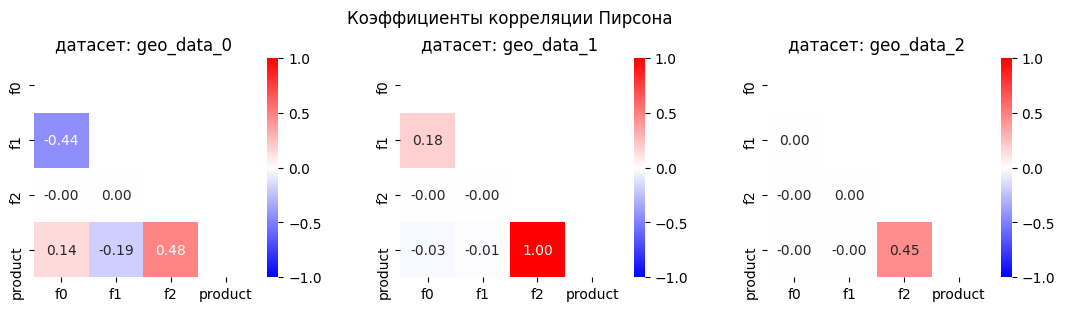

In [21]:
# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), constrained_layout=True)

# для каждого датасета строим матрицу корреляции
for i, df_name in enumerate(df_list):
    df  = eval(df_name)
    plt.sca(axes[i])

    corr_matrix(df)
    
    title = axes[i].get_title()
    axes[i].set_title('датасет: ' + df_name)

fig.suptitle(title);

**Выводы:**
- Значения коэффициентов корреляции Пирсона между входными признаками по модулю не превышают 0.5. Значит, мультиколлинеарности нет.
- С целевым признаком `product` сильнее всего связан признак `f2`, причём в датасете `geo_data_1` (т.е. для региона 1), коэффициент корреляции равен 1. Поэтому можно предположить, что модель линейной регрессии покажет наилучшее качество именно на данных `geo_data_1`.

Дополнительно исследуем совместное распределение признаков, построив диаграммы рассеяния для всех пар признаков в каждом датасете.

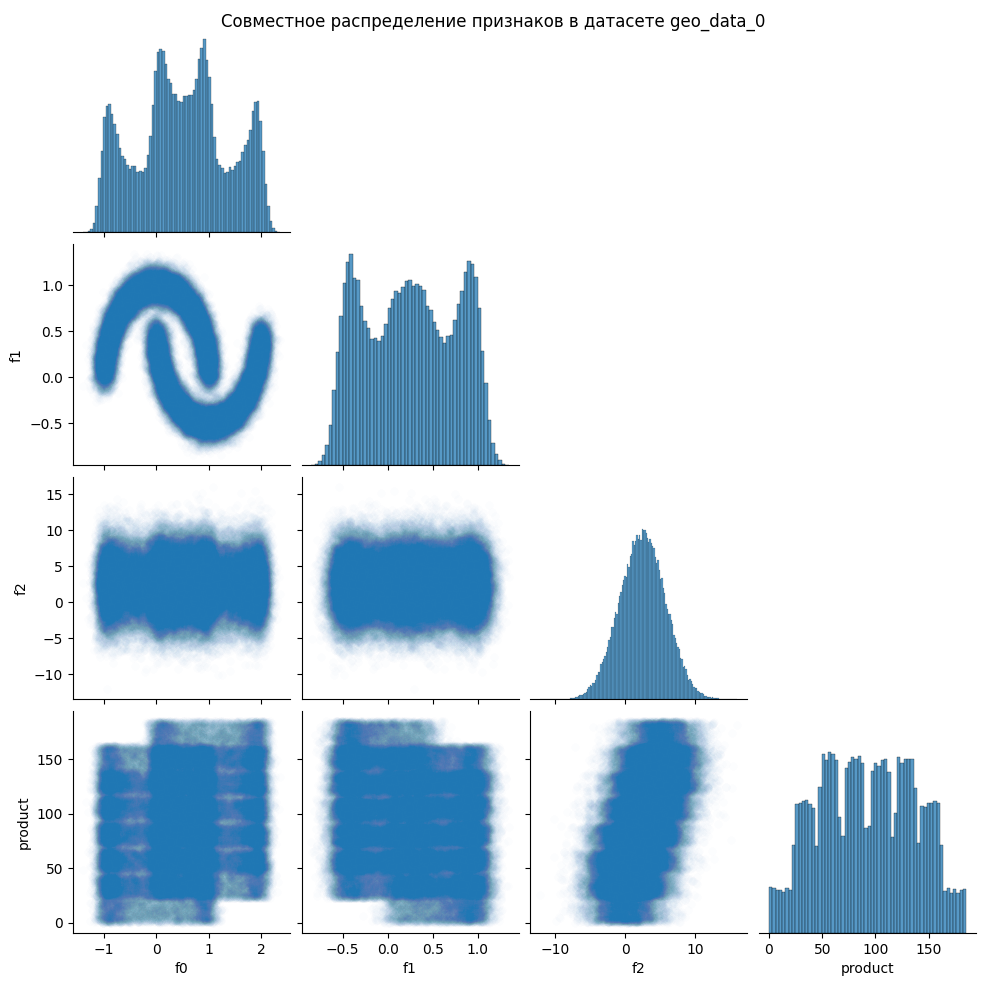

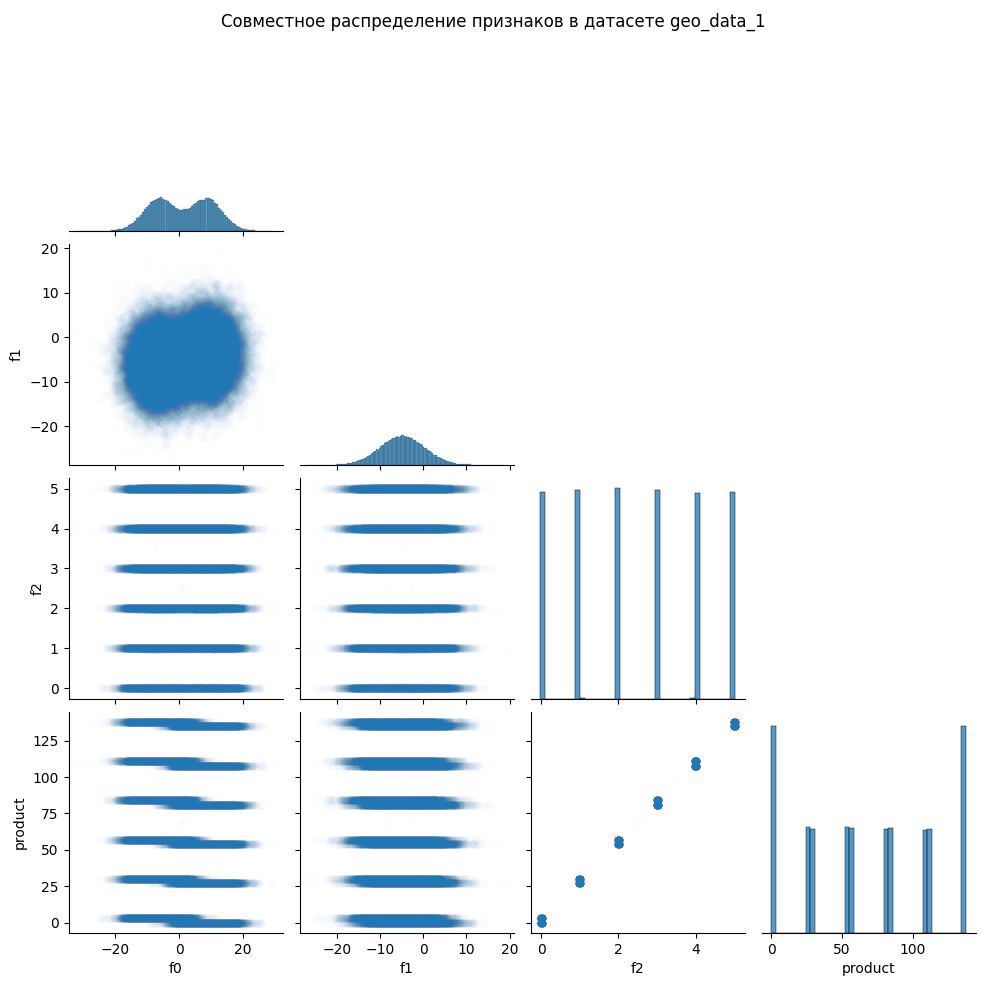

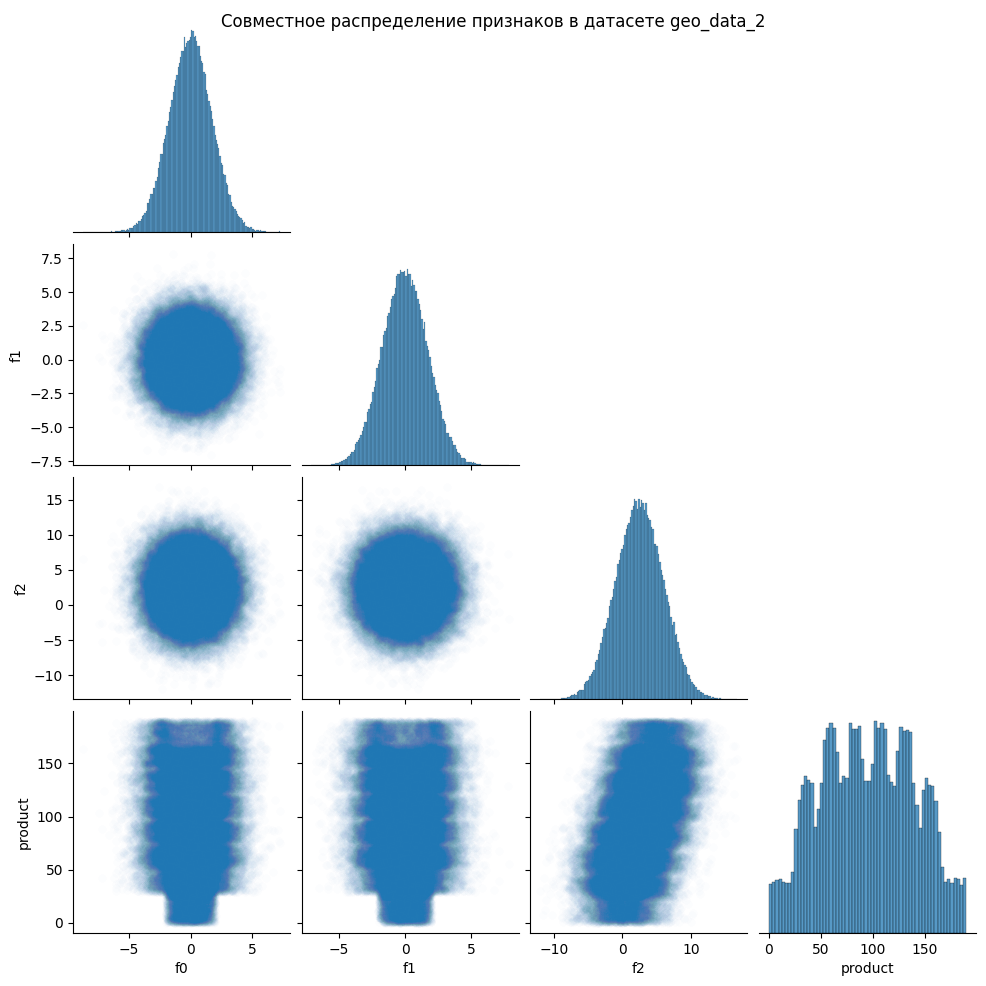

In [22]:
# для каждого датасета строим диаграммы рассеяния
for df_name in df_list:
    df  = eval(df_name)
    
    sns.pairplot(df, diag_kind='hist', corner=True, plot_kws={'alpha': 0.01})
    
    plt.gcf().suptitle('Совместное распределение признаков в датасете ' + df_name)
    plt.show()

Анализ диаграмм рассеяния подтверждает выводы, сделанные по результатам анализа матриц корреляции признаков.
- В датасете `geo_data_1` практически идеальная линейная зависимость целевого признака `product` от признака `f2`.
- В датасетах `geo_data_0` и `geo_data_2` тоже заметна линейная зависимость целевого признака `product` от признака `f2`, но значения входного признака имеют значительный разброс.

Также обнаружена интересная картина в совместном распределении признаков `f0` и `f1` в датасете `geo_data_0`: объекты (скважины) сгруппированы в два кластера. Возможно, имеет смысл разделить регион 0 на два региона, для которых отдельно обучать модель для предсказания запасов нефти в месторождениях. Однако кластеры линейно не разделимы, поэтому для поиска оптимальной границы разбиения региона 0 на два подрегиона в задаче кластеризации нужно будет использовать использовать модель, которая может находить нелинейные зависимости в данных, например, метод опорных векторов (SVM).

### Выводы

Результаты подготовки и анализа данных:

- Каждый из трёх датасетов содержит по 100,000 записей. Структура датасетов одинакова: текстовый id и четыре непрерывных количественных признака, один из которых целевой — `product` (объём запасов сырья в скважине).

- Пропущенные значения в датасетах отсутствуют.

- Записи с одинаковыми наборами признаков в датасетах отсутствуют.

- Значения id скважин в каждой из таблиц оказались не уникальны: имеются пары записей с одинаковыми id. Наиболее вероятная причина появления дубликатов с одинаковыми id и отличающимися значениями признаков — на одной и той же скважине были взяты две пробы. Нет оснований считать, что одна из записей достоверная, а другая нет, поэтому каждая группа записей с одинаковым id заменена на одну запись с усреднёнными по группе значениями признаков. После этого столбец id в таблицах установлен в качестве индекса.

- В разных датасетах попадаются одинаковые id скважин. Возможное объяснение этому в том, что id скважины — это хэш от её названия, поэтому если в разных регионах встречаются скважины с одинаковыми названиями, то и id у них будут совпадать. Поэтому нет достаточных оснований, чтобы считать, что это одни и те же скважины и из-за этого между регионами есть пересечения.

- Аномалии и сильные выбросы в данных отсутствуют, и в целом их распределения имеют симметричный вид. Поэтому для масштабирования входных признаков при подготовке данных для обучения ML модели подойдёт стандартизация с помощью скейлера `StandardScaler`.

- Регионы 0 и 2 имеют похожие характеристики, а регион 1 от них заметно отличается по характеристикам месторождений. При этом регионы 0 и 1 не однородны по характеристикам месторождений. 

- В регионе 0 объекты (скважины) сгруппированы в два кластера. Для получения более высокого качества прогноза имеет смысл в будущем разбить регион 0 на два подрегиона, для которых отдельно обучать модель для предсказания запасов сырья.

- Мультиколлинеарность между входными признаками отсутствует.

- С целевым признаком `product` сильнее всего связан признак `f2`, причём для региона 1 наблюдается практически идеальная линейная зависимость. Поэтому можно предположить, что модель линейной регрессии покажет наилучшее качество именно для региона 1.

## Обучение и проверка модели

### Сборка пайплайна

Соберём пайплайн для подготовки данных и обучения ML модели.
- Для масштабирования количественных признаков используем стандартизацию с помощью `StandardScaler`, предварительно с помощью `SimpleImputer` заполнив пропуски (если они есть) медианным значением признака. В полученных данных нет пропусков, но для универсальности модели лучше предусмотреть их обработку в пайплайне.
- В соответствии с условиями задачи, в качестве ML модели берём линейную регрессию `LinearRegression`.

In [23]:
# создаём пайплайн
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),
    StandardScaler(),
    LinearRegression()
)
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### Предсказание объёма запасов сырья

При предсказании объёма запасов сырья нужно как-то идентифицировать каждый регион. Обозначим каждый регион по номеру соответствующего ему датасета и создадим список с названиями регионов.

датасет | название региона
---- | ----
geo_data_0| region_0
geo_data_1 | region_1
geo_data_2 | region_2

In [24]:
# список с названиями регионов
region_list = [df_name.replace('geo_data', 'region') for df_name in df_list]
region_list

['region_0', 'region_1', 'region_2']

Обучим и проверим модель для каждого региона:
- Разобьём данные на тренировочную и валидационную выборки в соотношении 3:1 (т.е. доля валидационной выборки 0.25).
- Обучим модель на тренировочной выборке и сделаем предсказания на валидационной выборке.
- Предсказания модели на валидационной выборке и соответствующие им фактические значения объёма запасов сырья сохраним для дальнейшего использования.
- Рассчитаем средний предсказанный объём запасов сырья в одной скважине.
- Оценим ошибку предсказаний модели метрикой RMSE (корень среднеквадратичной ошибки).

Полученные результаты расчёта среднего объёма запасов сырья и RMSE модели сохраним в таблицу. 

Кроме того, сохраним сами обученные модели для каждого региона.

In [25]:
# словари для сохранения массивов предсказаний модели и фактических значений
predictions = {}
values = {}

# словарь для сохранения результатов
results_modeling = {
    'region': region_list,
    'product_mean': [],
    'product_rmse': []
}

# словарь для сохранения обученных моделей
models = {}

# цикл по регионам
for df_name, region in zip(df_list, region_list):
    # получаем датафрейм по названию
    df = eval(df_name)

    # отделяем целевой признак от входных
    X = df.drop(columns='product')
    y = df['product']
    
    # разбиваем данные на тренировочную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,
        test_size=0.25,
        random_state=RANDOM_STATE,
    )
    
    # обучаем модель на тренировочной выборке
    pipe.fit(X_train, y_train)
    # сохраняем копию обученной модели
    models[region] = deepcopy(pipe)

    # делаем предсказания на валидационной выборке
    y_pred = pipe.predict(X_valid)
    # сохраняем предсказания модели
    predictions[region] = y_pred

    # преобразуем pandas.Series в массив NumPy
    y_valid = y_valid.to_numpy()
    # сохраняем фактические значения
    values[region] = y_valid

    # средний предсказанный объём запасов сырья в одной скважине
    product_mean = y_pred.mean()
    # сохраняем результат расчёта
    results_modeling['product_mean'].append(product_mean)

    # метрика RMSE на валидационной выборке
    product_rmse = mean_squared_error(y_valid, y_pred, squared=False)
    # сохраняем результат расчёта
    results_modeling['product_rmse'].append(product_rmse)

# формируем таблицу с результатами
results_modeling = pd.DataFrame(results_modeling).set_index('region')

Представим результаты расчётов в табличной форме.

In [26]:
# выводим таблицу с результатами
(results_modeling
 .rename_axis('Регион')
 .rename(columns={
     'product_mean': 'Средний предсказанный объём запасов сырья в одной скважине (тыс. баррелей)',
     'product_rmse': 'RMSE модели (тыс. баррелей)'
 })
 .style
 .format('{:.3f}')
 .set_table_styles([dict(selector='th', props=[('max-width', '3in')])])
)

,Средний предсказанный объём запасов сырья в одной скважине (тыс. баррелей),RMSE модели (тыс. баррелей)
Регион,,
region_0,92.612,37.684
region_1,68.576,0.893
region_2,94.935,40.076


### Выводы

Для каждого из трёх регионов на валидационной выборке (1/4 от данных) рассчитан средний предсказанный объём запасов сырья в одной скважине и корень среднеквадратичной ошибки (RMSE) предсказаний. 
- Средний предсказанный объём запасов сырья в регионах 0 и 2 почти одинаков и значительно превышает таковой в регионе 1.
- RMSE предсказаний объёма запасов сырья в конкретной скважине для региона 1 значительно (более чем на порядок величины) меньше, чем для регионов 0 и 2, у которых значения RMSE близки. Таким образом, точность предсказаний модели намного выше для региона 1. Скорее всего, причина этого в очень сильной линейной связи в данных для региона 1 между входным признаком `f2` и целевым признаком — объёмом запасов нефти в скважине, а также малом разбросе значений целевого признака при фиксированном значении признака `f2`, что было установлено при анализе корреляций. 
- Для регионов 0 и 2 точность предсказаний модели невысока, RMSE всего лишь в 2-3 раза меньше среднего значения. Причина этого в более слабой линейной связи целевого признака с входными, особенно с наиболее значимым признаком `f2`, для которого коэффициент корреляции с целевым более чем в 2 раза меньше, чем в случае региона 1, вследствие большого разброса значений целевого признака при фиксированном значении прогнозирующего признака `f2`.

Таким образом, анализ результатов прогноза запасов сырья показывает:
- Модель линейной регрессии намного лучше предсказывает объём запасов сырья в регионе 1, чем в регионах 0 и 2.  Поэтому, несмотря на меньший средний объём запасов сырья в месторождениях региона 1, он может оказаться более прибыльным за счёт более точного выбора скважин с наибольшим объёмом запасов сырья.

## Подготовка к расчёту прибыли

### Задание параметров расчёта

В соответствии с принципом разделения бизнес-логики и технического кода, для всех ключевых параметров, заданных в условиях поставленной задачи, создадим константы. 

В результате все параметры, необходимые для расчёта прибыли, будут собраны в одном месте, где их при необходимости можно поменять. 

In [ ]:
# количество точек, которые исследуют при разведке региона
NUM_SITES = 500

# количество скважин в регионе для разработки  
NUM_WELLS = 200

# бюджет на разработку скважин в регионе (руб.)
BUDGET = 10_000_000_000

# доход от одной единицы сырья (1 единица сырья = 1000 баррелей)
INCOME_PER_UNIT = 450_000

# наибольшая предельная вероятность убытков
MAX_RISK_OF_LOSSES = 0.025

### Расчёт уровня безубыточной разработки скважины

Рассчитаем достаточный объём запасов сырья для безубыточной разработки новой скважины.

Разработка скважины будет безубыточной при условии
$$income = well\_cost,$$
где $income$ — доходы от добываемого сырья, $well\_cost$ — расходы на разработку скважины.

Расходы на разработку одной новой скважины:
$$well\_cost = \frac{budget}{N_{wells}},$$
где $budget$ — бюджет на разработку скважин в регионе, $N_{wells}$ — количество скважин в регионе для разработки.

Доходы от добываемого сырья:
$$income = product \cdot income_{unit},$$
где $product$ — объём запасов сырья в скважине (в единицах сырья, 1 единица сырья = 1000 баррелей), $income_{unit}$ — доход от одной единицы сырья.

Таким образом, достаточный объём запасов сырья для безубыточной разработки новой скважины рассчитывается по формуле
$$product_{break\_even} = well\_cost /income_{unit}.$$

In [28]:
# расходы на разработку одной новой скважины
well_cost = BUDGET / NUM_WELLS

# достаточный объём сырья для безубыточной разработки новой скважины
product_break_even = well_cost / INCOME_PER_UNIT

print('Расходы на разработку одной новой скважины: '
      f'{well_cost:,.2f} руб.')
print()
print('Достаточный объём запасов сырья для безубыточной разработки новой скважины: '
      f'{product_break_even:.3f} тыс. баррелей')

Расходы на разработку одной новой скважины: 50,000,000.00 руб.

Достаточный объём запасов сырья для безубыточной разработки новой скважины: 111.111 тыс. баррелей


Рассчитаем также средний фактический запас сырья в одной скважине для каждого региона по валидационной выборке.

In [29]:
# цикл по регионам
for region in region_list:
    # средний фактический объём запасов сырья в одной скважине
    values_mean = values[region].mean()
    
    print('Регион:', region)
    print('Средний фактический объём запасов сырья в одной скважине: '
          f'{values_mean:.3f} тыс. баррелей')
    print()

Регион: region_0
Средний фактический объём запасов сырья в одной скважине: 92.389 тыс. баррелей

Регион: region_1
Средний фактический объём запасов сырья в одной скважине: 68.583 тыс. баррелей

Регион: region_2
Средний фактический объём запасов сырья в одной скважине: 95.256 тыс. баррелей



Средний фактический объём запасов сырья мало отличается от предсказанного моделью, поэтому использование для оценки среднего объёма запасов сырья предсказаний модели оправдано.

Как показали расчёты, для всех трёх регионов средний предсказанный объём запасов сырья в скважине составляет меньше 95 тыс. баррелей.

Это означает, что если выбирать скважины для разработки случайным образом, то убытки практически неизбежны. Особенно это касается региона 1, в котором низкий средний объём запасов сырья. Только при большом везении можно получить прибыль, если фактический средний объём запасов сырья в выбранных для разработки скважинах окажется выше предсказанного.

Рассчитаем риск того, что разработка случайно выбранной скважины в регионе окажется убыточной.

In [30]:
# словарь для сохранения результатов
results_random = {
    'region': region_list,
    'risk_of_losses': []
}

# цикл по регионам
for region in region_list:
    # риск убытков
    risk_of_losses = (values[region] < product_break_even).mean()
    results_random['risk_of_losses'].append(risk_of_losses)

# формируем таблицу с результатами
results_random = pd.DataFrame(results_random).set_index('region')

In [31]:
# выводим таблицу с результатами
(results_random
 .rename_axis('Регион')
 .rename(columns={
     'risk_of_losses': 'Риск убытков при случайном выборе скважины для разработки',
 })
 .style
 .format('{:.2%}')
 .set_table_styles([dict(selector='th', props=[('max-width', '3in')])])
)

,Риск убытков при случайном выборе скважины для разработки
Регион,
region_0,63.62%
region_1,83.37%
region_2,61.66%


Как и ожидалось, риск убытков при случайном выборе скважины для разработки значительно превышает 50%, причём риск убытков максимален для региона 1.

### Выводы

Достаточный объём запасов сырья для безубыточной разработки новой скважины составляет ≈111.тыс. баррелей, что превышает средний предсказанный объём запасов сырья в скважинах для всех трёх регионов (менее 95 тыс. баррелей).

Таким образом, если выбирать скважины для разработки случайным образом, то убытки практически неизбежны. Риск убытков при случайном выборе скважин для разработки значительно превышает 50%, что заведомо не соответствует условиям задачи.

Поэтому добиться прибыльности и обеспечить приемлемый риск убытков при разработке месторождений можно только если выбирать для разработки скважины не случайно, а используя предсказания обученной ML модели для выбора скважин с наибольшим предсказанным объёмом запасов сырья, чтобы максимизировать прибыль. 

## Расчёт прибыли и рисков

### Методика расчёта прибыли

Для разработки выбираются скважины с наибольшими значениями объёмом запасов сырья, предсказанными обученной ML моделью. 

Прибыль рассчитывается как разность между суммарным доходом от разработки выбранных скважин и бюджетом на их разработку:
$$profit = \left(\sum_{i=1}^{N_{wells}}{product\_selected_i}\right) \cdot income_{unit} - budget,$$
где $product\_selected_i$ — объём запасов сырья в $i$-й выбранной скважине (в единицах сырья, 1 единица сырья = 1000 баррелей), $N_{wells}$ — количество скважин в регионе для разработки, $income_{unit}$ — доход от одной единицы сырья, $budget$ — бюджет на разработку скважин в регионе.

Создадим функцию `get_profit` для расчёта прибыли по фактическим значениям `values` объёма запасов сырья в выбранных скважинах и предсказаниям модели `predictions`.

In [32]:
def get_profit(values: pd.Series, predictions: pd.Series) -> np.float64:
    """
    Расчёт прибыли от разработки выбранных скважин.
    values - фактические значения объёма запасов сырья в выбранных скважинах,
    predictions - предсказанные значения объёма запасов сырья в выбранных скважинах.
    """
    # сортируем предсказания модели по убыванию значений
    predictions_sorted = predictions.sort_values(ascending=False)
    
    # отбираем NUM_WELLS фактических значений с наибольшими значениями предсказаний
    values_selected = values[predictions_sorted.index][:NUM_WELLS]

    # расчёт прибыли
    profit = values_selected.sum() * INCOME_PER_UNIT - BUDGET
    
    return profit

### Расчёт прибыли и рисков с помощью Bootstrap

Рассчитаем ожидаемую прибыль и риск убытков для каждого региона при выборе скважин для разработки с наибольшим предсказанным моделью объёмом запасов сырья.

Для этого используем процедуру *Bootstrap*, которая позволяет получить распределение нужной статистики (в данном случае — прибыли) путём генерации множества подвыборок из исходной выборки. Количество генерируемых подвыборок задано константой `NUM_SUBSAMPLES`.

По полученному в результате процедуры *Bootstrap* распределению прибыли рассчитаем интересующие характеристики: 
- среднюю прибыль, т.е. ожидаемую прибыль от разработки скважин в регионе;
- 95%-й доверительный интервал для прибыли, т.е. интервал, в котором с вероятностью 95% будет находиться значение прибыли;
- риск убытков, т.е. вероятность того, что прибыль окажется отрицательной.

In [33]:
# создаём генератор случайных состояний для генерации подвыборок в бутстрапе
random_state = np.random.RandomState(RANDOM_STATE)

# словарь для сохранения результатов
results = {
    'region': region_list,
    'mean_profit': [],
    'confidence_interval_lower': [],
    'confidence_interval_upper': [],
    'risk_of_losses': []
}

# цикл по регионам
for region in region_list:
    # преобразуем массивы NumPy в pandas.Series
    values_region = pd.Series(values[region])
    predictions_region = pd.Series(predictions[region])

    # список для значений прибыли
    profit = []
    
    # Bootstrap: цикл по подвыборкам
    for _ in range(NUM_SUBSAMPLES):
        # подвыборка фактических значений
        values_subsample = values_region.sample(
            n=NUM_SITES, 
            replace=True, 
            random_state=random_state
        )
        # подвыборка предсказаний модели
        predictions_subsample = predictions_region[values_subsample.index]
        # считаем прибыль
        subsample_profit = get_profit(values_subsample, predictions_subsample)
        # сохраняем значение в список
        profit.append(subsample_profit)

    # преобразуем список в pandas.Series
    profit = pd.Series(profit)

    # средняя прибыль
    mean_profit = profit.mean()
    # сохраняем результат расчёта
    results['mean_profit'].append(mean_profit)

    # границы 95%-го доверительного интервала
    profit_lower, profit_upper = profit.quantile([0.025, 0.975])
    # сохраняем результаты расчёта
    results['confidence_interval_lower'].append(profit_lower)
    results['confidence_interval_upper'].append(profit_upper)

    # риск убытков
    risk_of_losses = (profit < 0).mean()
    # сохраняем результат расчёта
    results['risk_of_losses'].append(risk_of_losses)

# формируем таблицу с результатами
results = pd.DataFrame(results).set_index('region')

In [34]:
# выводим таблицу с результатами
(results
 .rename_axis('Регион')
 .rename(columns={
     'mean_profit': 'Средняя прибыль (руб.)',
     'confidence_interval_lower': 'Нижняя граница 95%-го доверительного интервала для прибыли (руб.)',
     'confidence_interval_upper': 'Верхняя граница 95%-го доверительного интервала для прибыли (руб.)',
     'risk_of_losses': 'Риск убытков',
 })
 .style
 .format('{:,.2f}')
 .format({'Риск убытков': '{:.2%}'})
 .set_table_styles([dict(selector='th', props=[('max-width', '3in')])])
)

,Средняя прибыль (руб.),Нижняя граница 95%-го доверительного интервала для прибыли (руб.),Верхняя граница 95%-го доверительного интервала для прибыли (руб.),Риск убытков
Регион,,,,
region_0,"431,751,927.44","-118,097,412.09","939,845,151.01",5.60%
region_1,"498,528,804.72","72,384,405.95","935,742,970.00",1.00%
region_2,"395,099,000.33","-134,389,935.34","919,605,452.46",8.60%


Анализ результатов:
- Максимальная ожидаемая прибыль от разработки скважин и минимальный риск убытков получились для региона 1. Для него также получился самый узкий доверительный интервал прибыли. Малая средняя ошибка предсказаний модели для региона 1 позволяет с большей вероятностью выбрать самые лучшие скважины для разработки с наибольшим объёмом запасов сырья, и за счёт этого увеличить прибыль.

- Более высокая ошибка предсказаний модели для регионов 0 и 2 привела к тому, что ожидаемая прибыль от добычи нефти в них ниже, а риск убытков выше.

### Выбор лучшего региона для разработки скважин

В соответствии с условиями поставленной задачи, после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше заданного предельного значения. Среди них для разработки скважин нужно выбрать регион с наибольшей средней прибылью.

In [35]:
# определяем лучший регион для разработки скважин
best_region = (
    results
    .query('risk_of_losses < @MAX_RISK_OF_LOSSES')
    ['mean_profit']
    .idxmax()
)
print(f'Регион с риском убытков меньше {MAX_RISK_OF_LOSSES:.1%} '
      'и наибольшей средней прибылью:', best_region)

Регион с риском убытков меньше 2.5% и наибольшей средней прибылью: region_1


Из рассматриваемых регионов условию по уровню риска удовлетворяет только регион 1. Он же занял первое место по средней прибыли.

Таким образом, выбор очевиден: следует рекомендовать для разработки скважин именно регион 1.

### Выводы

1. Наиболее перспективный регион для разработки скважин, удовлетворяющий критерию низкого риска убытков и для которого ожидаемая прибыль максимальна — это **регион 1**, который получил обозначение `region_1` и соответствует датасету `geo_data_1`.
   - Причина, по которой для региона 1 получились наилучшие результаты, заключается в наличии сильной линейной связи между одним из признаков, характеризующих скважину — `f2`, и объёмом запасов сырья в ней. Благодаря этому используемая для прогнозирования объёма запасов сырья в скважинах модель линейной регрессии для этого региона показала наиболее высокую точность предсказаний. В свою очередь, лучшее качество предсказаний позволяет с большей вероятностью выбрать самые лучшие скважины для разработки с наибольшим объёмом запасов сырья, и за счёт этого максимизировать прибыль и снизить риск убытков.

3. Более высокий риск убытков при разработке скважин в регионах 0 и 2 обусловлен более высокой средней ошибкой предсказаний модели, которая вызвана меньшей корреляцией прогнозирующих признаков с целевым  — объёмом запасов сырья в скважине.
   - Из-за более низкой точности предсказаний модели для этих регионов меньше эффективность отбора скважин по объёму запасов сырья, что негативно сказывается на прибыли и повышает риск убытков.

## Общий вывод

1. В рамках проекта была поставлена **задача** на основании данных геологоразведки выбрать регион для бурения и разработки скважин, где добыча нефти принесёт наибольшую прибыль при низком риске убытков.

2. Компанией предоставлены табличные **данные** для трёх нефтеносных регионов, в которых по 100,000 записей. Данные содержат текстовый id скважины, три количественных признака, характеризующих характеризующих нефть, и объём её запасов в скважине.

3. Проведена **предобработка** данных:
    - Установлено, что пропущенные значения и записи с одинаковыми наборами признаков в датасетах отсутствуют.
    - Обнаруженные записи с одинаковым id заменены на одну запись с усреднёнными по группе с одинаковым id значениями признаков.

4. Проведён **исследовательский анализ** данных, который показал:
    - Аномалии и сильные выбросы в данных отсутствуют.
    - Имеются отличия в распределениях признаков месторождений между регионами:
        - Регион 1 выделяется среди других регионов, а регионы 0 и 2 в целом похожи.
        - В регионе 0 скважины сгруппированы в два кластера по своим признакам. Возможно, имеет смысл в будущем разбить регион 0 на два подрегиона.
    - Мультиколлинеарность между входными признаками отсутствует.
    - С целевым признаком (объёмом запасов нефти в скважине) сильнее всего связан признак `f2`, причём для региона 1 наблюдается практически идеальная линейная зависимость.

5. Обучена и проверена **модель** (линейная регрессия) для предсказания объёма запасов в новых скважинах каждого региона.
    - Подготовка данных для модели (заполнение пропусков и масштабирование количественных признаков) выполнена в пайплайне.
    - Данные разбиты на тренировочную и валидационную выборки в соотношении 3:1.
    - Модель обучена на тренировочной выборке, на валидационной выборке получены предсказания объёма запасов сырья. 
    - Получены **результаты**:
        - Средний предсказанный объём запасов сырья в одной скважине в регионах 0 и 2 почти одинаков и значительно превышает таковой в регионе 1.
        - Метрика RMSE (корень среднеквадратичной ошибки) предсказаний объёма запасов сырья в конкретной скважине для региона 1 значительно (более чем на порядок величины) меньше, чем для регионов 0 и 2, у которых значения RMSE близки. Таким образом, точность предсказаний модели намного выше для региона 1. Причина этого в очень сильной линейной связи в данных для региона 1 между входным признаком `f2` и целевым признаком — объёмом запасов нефти в скважине, что было установлено при анализе корреляций. 
        - Для регионов 0 и 2 точность предсказаний модели невысока, RMSE всего лишь в 2-3 раза меньше среднего значения. Причина этого в более слабой линейной связи целевого признака с наиболее значимым прогнозирующим признаком `f2`.
    
6. Проведён **анализ результатов** предсказаний модели для каждого региона, который показал:
    - Модель линейной регрессии намного лучше предсказывает объём запасов сырья в конкретной скважине в регионе 1, чем в регионах 0 и 2.  Поэтому, несмотря на меньший средний объём запасов сырья в месторождениях региона 1 по сравнению с регионами 0 и 2, он может оказаться более прибыльным за счёт более точного выбора скважин с наибольшим объёмом запасов сырья.

7. Проведена **подготовка к расчёту прибыли**:
    - Все параметры, необходимые для расчёта прибыли, заданы в виде констант.
    - Рассчитан достаточный объём запасов сырья для безубыточной разработки новой скважины: ≈111 тыс. баррелей. При этом средний предсказанный объём запасов сырья в скважине для всех трёх регионов составляет меньше 95 тыс. баррелей. Это означает, что если выбирать скважины для разработки случайным образом, то убытки практически неизбежны. 
    - Рассчитанный риск убытков при случайном выборе скважины для разработки значительно превышает 50%, причём риск убытков максимален для региона 1.
    - Вывод: чтобы добиться прибыльности и обеспечить приемлемый риск убытков при разработке месторождений, нужно выбирать скважины не случайно, а используя предсказания обученной ML модели для выбора скважин с наибольшим предсказанным объёмом запасов сырья. 

8. Проведён **анализ возможной прибыли и рисков**.
    - Сформулирована методика расчёта прибыли, которая оформлена в виде отдельной функции, чтобы разделить бизнес-логику и технический код для расчётов.
    - С применением техники *Bootstrap* для каждого региона рассчитаны средняя ожидаемая прибыль, 95%-й доверительный интервал для прибыли и риск убытков при выборе скважин для разработки с наибольшим предсказанным моделью объёмом запасов сырья.
    - Максимальная ожидаемая прибыль от разработки скважин и минимальный риск убытков получились для региона 1, для которого также получился самый узкий доверительный интервал прибыли. Причина этого в том, что малая средняя ошибка предсказаний модели для региона 1 позволяет с большей вероятностью выбрать самые лучшие скважины для разработки с наибольшим объёмом запасов сырья.
    - Более высокая ошибка предсказаний модели для регионов 0 и 2 приводит к тому, что эффективность отбора скважин по объёму запасов сырья оказывается меньше, что негативно сказывается на прибыли и повышает риск убытков.

9. Выбран **наиболее перспективный регион для разработки скважин**, удовлетворяющий критерию низкого риска убытков и для которого ожидаемая прибыль максимальна — это **регион 1**, соответствующий датасету `geo_data_1`.
    - Преимущество региона 1 в том, что благодаря наличию сильной линейной связи объёма запасов сырья с одним из признаков, характеризующих скважину, и малому разбросу значений целевого признака при фиксированном значении этого признака, для этого региона лучше всего работает модель, используемая для прогнозирования объёма запасов сырья в скважинах. Более высокая точность предсказаний модели позволяет эффективно выбирать самые лучшие скважины для разработки с наибольшим объёмом запасов сырья, и за счёт этого максимизировать прибыль и снизить риск убытков.

10. Дополнительные рекомендации:
    - Чтобы повысить точность предсказаний модели для других регионов, надо сделать данные менее шумными — снизить разброс значений прогнозирующих признаков при фиксированном значении целевого признака. Возможно, в этом поможет разделение крупных регионов на подрегионы с более узким распределением характеристик скважин.